# __Puffins__

## NB 04 - Estimating uncertainties and standard errors on model terms

So far, we've seen how to model some (time-series) data with a feature-embedded and feature-weighted regression model using __puffins__. We've seen how different types of regression models perform on the same data, and we've also see how to tune the hyper-parameters of our model. 

Now, in this notebook, we're going to look at three different methods for assessing the uncertainties and standard errors on the terms in our models.

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt

from puffins.tuner import Tuner
from puffins.weight_functions import matern32
from puffins.data import TimeSeries,LinearModel
from puffins.uncertainties import UncertaintyEstimator
from puffins.basis_functions import basis_constant, basis_linear

np.random.seed(42) # to enforce reproducibility
RCOND = 1e-14 # numerical rounding for matrix conditioning
plotnum=1

## Instantiate the data and model classes

In [2]:
time, flux = np.loadtxt('../data/ugru.dat').T
flux_err = np.random.normal(0,0.005,len(flux))
period = 1.88045
n_harmonics = 100
feature_weighting_width = 0.5

## Parameter tuning

As we saw in the last notebook, the difference between randomly chosen and optimised parameters can be very stark on the resulting model. Therefore, we want to make sure that our model is as good a representation of the data as possible before we start to estimate the model uncertaintes. 

In [3]:
data = TimeSeries(time, flux)
fwls = LinearModel('fw', basis_functions=[basis_constant,], feature_embedding='fourier', 
                   feature_weighting_function=matern32, feature_weighting_width=feature_weighting_width,
                   period=period, n_harmonics=100, W=None)

In [4]:
joint_ = {'feature_weighting_width': [0.001,1,'uniform'], 'period': [1.87,1.89,'uniform']}
joint_tuner = Tuner(fwls, hyperpars=joint_, n_trials=200, direction='minimize')
joint_tuner.run_tune(data.predictors, data.targets)

[I 2025-02-07 15:51:49,591] A new study created in memory with name: no-name-53881c9e-3212-4602-a84b-eb101cdb5623
[I 2025-02-07 15:51:49,683] Trial 0 finished with value: 0.007463692239346467 and parameters: {'feature_weighting_width': 0.7142292680133613, 'period': 1.8739029489452292}. Best is trial 0 with value: 0.007463692239346467.
[I 2025-02-07 15:51:49,754] Trial 1 finished with value: 0.00894381533422166 and parameters: {'feature_weighting_width': 0.8155915998544844, 'period': 1.887015697783962}. Best is trial 0 with value: 0.007463692239346467.
[I 2025-02-07 15:51:49,895] Trial 2 finished with value: 0.0018672495893446296 and parameters: {'feature_weighting_width': 0.22535016872150446, 'period': 1.8753074657469764}. Best is trial 2 with value: 0.0018672495893446296.
[I 2025-02-07 15:51:49,972] Trial 3 finished with value: 0.0017562473626849492 and parameters: {'feature_weighting_width': 0.3622549112180056, 'period': 1.8763724322012085}. Best is trial 3 with value: 0.001756247362

In [5]:
print(joint_tuner)

Tuner:
 feature_weighting_width: 0.03989033027362253
period: 1.8804753725020271


In [6]:
fwls.set_X_kwargs(update=True, **joint_tuner.best_hyperpars)
fwls.set_X_train(data.predictors)
fwls.train(data.targets)

## Optimal model 
At this point, we have our __optimal__ model. Now, we want to determine how robust this model is. Normally, if we are using an ordinary or weighted least-squares regressor, we can use the standard errors formula to get confidence intervals on our model coefficients. However, the feature weighting that we've introduced prevents us from doing so because it _biases_ our model. Instead, we have to use sampling methods. To do this, __puffins__ has three methods for estimating the uncertainties on regression coefficients. 

These three methods are: i) __jackknifing__, ii) __Monte Carlo__ simulations, and iii) __Markov Chain Monte Carlo__ simulations.

## Jack-knifing

Broadly speaking, __jackknifing__ is a method of resampling our data to get an empirical estimate of the variance of model parameters. There are several _flavours_ of jackknifing that we can use, with slight differences in their applications. 

First, we have traditional jackknifing, or __delete-1 jackknifing__, also known as __Leave-One-Out Cross-Validation__ (LOOCV). LOOCV entails systematically deleting one data-point at a time and re-running the model fit to the remaining data, then estimating the variance with the following formula:

$\widehat{Var}_{LOOCV} = \frac{n-1}{n} \sum_{i=1}^n \left( \hat{\theta}_{i} - \bar{\theta} \right)^2$, 

where $n$ is the number of datapoints, $\theta$ is the j-dimensional estimator (model parameter vector or statistic), and $\bar{\theta}$ is the average value of $\theta$ across all $i$ jackknife iterations ([Efron & Tibshirani, 1993](https://www.cambridge.org/core/journals/psychometrika/article/abs/b-efron-and-r-j-tibshirani-1993-an-introduction-to-the-bootstrap-new-york-chapman-hall-xvi-436-pp-isbn-04120423t2-5000/D7CC806A82BF7AA651C2BBF745D58017)).

For large $n$ datasets, doing a full LOOCV run might be computationally prohibitive. In light of that, clever statisticians have developed other versions of jackknifing that account for removing $d$ points at a time. This form of jackknifing is creatively referred to as __delete-d jackknifing__. The variance from delete-d jackknifing is given by:

$\widehat{Var}_{DdJK} = \frac{n-d}{d \dot m} \sum_{i=1}^m \left( \hat{\theta}_{i} - \bar{\theta} \right)^2$, 

where $d$ is the number of data points that we delete per iteration, and $m$ is the total number of ways that we can delete $d$ out of $n$ datapoints, e.g. $\binom{n}{d}$ ([Shao & Tu, 1995](https://link.springer.com/book/10.1007/978-1-4612-0795-5)). Alternatively, if $m$ is prohibitively large, one can take a sufficiently large $\tilde{m}$ that enables the estimator to be a reasonable representation the resulting parameter space.

Again, $m=\binom{n}{d}$ might be a prohibitively large number of iterations to run depending on your dataset, so we now come to __Grouped Jackknifing__. In __Grouped Jackknifing__, we split the data evenly into G groups and refit our model to each Group. The variance for __Grouped Jackknifing__ is given by:

$\widehat{Var}_{GJK} = \frac{G-1}{G} \sum_{i=1}^G \left( \hat{\theta}_{i} - \bar{\theta} \right)^2$, 

Where G is the number of groups ([Miller, 1964](https://www.jstor.org/stable/2238296)).

In all cases, we can construct confidence intervals (CIs) using the standard formulae drawing critical values from either a Normal or t-score distribution.

### A comment on the construction of confidence intervals

While in the case of large n datasets the critical values for the t-disribution converges to the Normal distribution, in the case of smaller $n$ the t-distribution has much larger tails to reflect the uncertainty of using fewer datapoints. As such, the critical value for 95% CIs is given as $\approx2.26$ for a t-distribution and $\approx1.96$ for small n, resulting in larger CIs when using the t-distribution. 


## Monte Carlo simulations

__Monte Carlo__ simulations offer a way of empirically estimating the variance of model parameters by repeatedly sampling your data under some assumptions. At each simulation or realisation of the data, you re-fit your model and then analyse the resulting distribution of your model parameters. This approach is particularly useful when analytical variance calculations are difficult or even inappropriate due to non-linearity in your  model, or non-Normally distributed uncertainties on your data. In this use case, we follow the implementation from the [Numerical Recipes in C textbook](https://www.cec.uchile.cl/cinetica/pcordero/MC_libros/NumericalRecipesinC.pdf).


## Markov Chain Monte Carlo

Taking this one step further, we can wrap our model into a Bayesian framework, whereby we assume that we have some _prior_ knowledge of our model parameters that we want to incorporate into our analysis. Bayes' theorem is given by:

$P\left( \theta | d \right) = \frac{ P\left( d | \theta \right) P\left( \theta \right) }{ P\left( d \right)}$, 

where $d$ is our data, $\theta$ are our model parameters that we want make inferences of, $P\left( \theta \right)$ is the prior information on our model parameters, $P\left( d | \theta \right)$ is the likelihood function (sometimes written as $\mathcal{L}\left( d | \theta \right)$), $P\left( \theta | d \right)$ is the posterior distribution of our model parameters, and  $P\left( d \right)$ is effectively a normalisation factor. In plain words, the likelihood function is a way of estimating how likely the data are, given, or assuming a generative model with parameters $\mathcal{M}\left( \theta \right)$, while our posterior distribution is a represenation of how likely a given set of parameters $\theta$ is, given the data $d$. In our case, the likelihood function is the OLS, Ridge regression, or FWLS.

Technically, if both your data and model are well behaved, there is an analytical solution to this. However, in reality, this is seldom the case. Instead, there is a whole industry that develops numerical sampling methods to approximate the posterior distribution! In this code, we make use of the Affine Invariant Ensemble Sampler emcee ([Foreman-Mackey et al., 2013](https://arxiv.org/abs/1202.3665)).

We derive empirical confidence intervals from the data in the form of $\alpha$% Highest Posterior Density intervals.

## Comparison

__puffins__ allows for the user to instantiate an UncertaintyEstimator class and use any or all of the methods described above to estimate parameter variances and confidence intervals! Below, we'll run a Grouped Jackknife example, a Monte Carlo example, and a Markov Chain Monte Carlo (MCMC) example.

In [7]:
esimator = UncertaintyEstimator(data, fwls)

In [8]:
## Grouped Jackknife
n_groups = 50
n_delete = 5000# 15000/n_groups
gjk = esimator.run_grouped_jackknife_sampling(n_groups=n_groups, n_delete=n_delete)

Grouped Jackkinfe Sampling: 100%|██████████| 50/50 [00:04<00:00, 11.40it/s]


In [9]:
## Delete-d Jackknife
n_groups = 1000
n_delete = 8000
ddjk = esimator.run_delete_d_jackknife_sampling(n_groups=n_groups, n_delete=n_delete)

Delete-d Jackkinfe Sampling: 100%|██████████| 1000/1000 [00:30<00:00, 33.32it/s]


In [10]:
## Monte Carlo
mcs = esimator.run_monte_carlo_sampling(target_uncertainties=abs(flux_err),n_samples=1000)

Monte Carlo Sampling: 100%|██████████| 1000/1000 [00:34<00:00, 28.76it/s]


In [11]:
## Markov Chain Monte Carlo

## It's like 95% implemented, I just haven't pushed it yet.

In [12]:
def get_delete_d_jk_var( 
                        n_data: int,
                        estimators: np.ndarray, 
                        n_groups: int,
                        n_delete: int, 
                       )-> np.ndarray:
    mean_ = np.mean(estimators, axis=0)
    lead = (n_data-n_delete)/(n_delete*n_groups)
    var_ = lead * np.nansum((estimators - mean_)**2, axis=0)
    return var_

/var/folders/0t/dn2hb3px135gyc8xpdtmcx080000gp/T/ipykernel_93867/2840708348.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels([f'{x:.4g}' for x in axes[i].get_xticks()])
/var/folders/0t/dn2hb3px135gyc8xpdtmcx080000gp/T/ipykernel_93867/2840708348.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels([f'{x:.4g}' for x in axes[i].get_xticks()])
/var/folders/0t/dn2hb3px135gyc8xpdtmcx080000gp/T/ipykernel_93867/2840708348.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels([f'{x:.4g}' for x in axes[i].get_xticks()])
/var/folders/0t/dn2hb3px135gyc8xpdtmcx080000gp/T/ipykernel_93867/2840708348.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of t

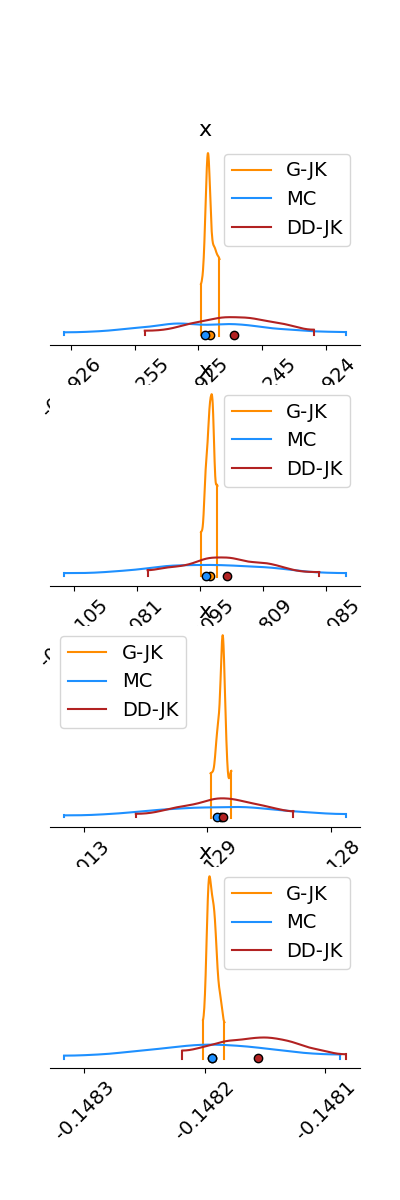

In [13]:
import arviz as az

fig, axes = plt.subplots(4, 1, figsize=(4, 12))

# Extract the relevant coefficients
gjk_coefs = gjk['sampled_coefs'][:, 1:5]
mcs_coefs = mcs['sampled_coefs'][:, 1:5]
ddjk_coefs = ddjk['sampled_coefs'][:, 1:5]

for i in range(4):
    az.plot_density([gjk_coefs[:, i], mcs_coefs[:,i], ddjk_coefs[:,i] ], ax=axes[i], colors=['darkorange', 'dodgerblue','firebrick'], data_labels=['G-JK', 'MC','DD-JK'], hdi_prob=0.95)
    axes[i].set_xticklabels([f'{x:.4g}' for x in axes[i].get_xticks()])
    axes[i].tick_params(axis='x', rotation=45)
plt.show()

We can see from this that the Grouped Jackknife results in the smallest errors, the Delete-d has a larger distribution of parameter values, and the Monte Carlo simulations have larger errors. Of course in this case, the uncertainties on the data that we used are synthetic, but this pattern will generally hold as we'll see with another example.

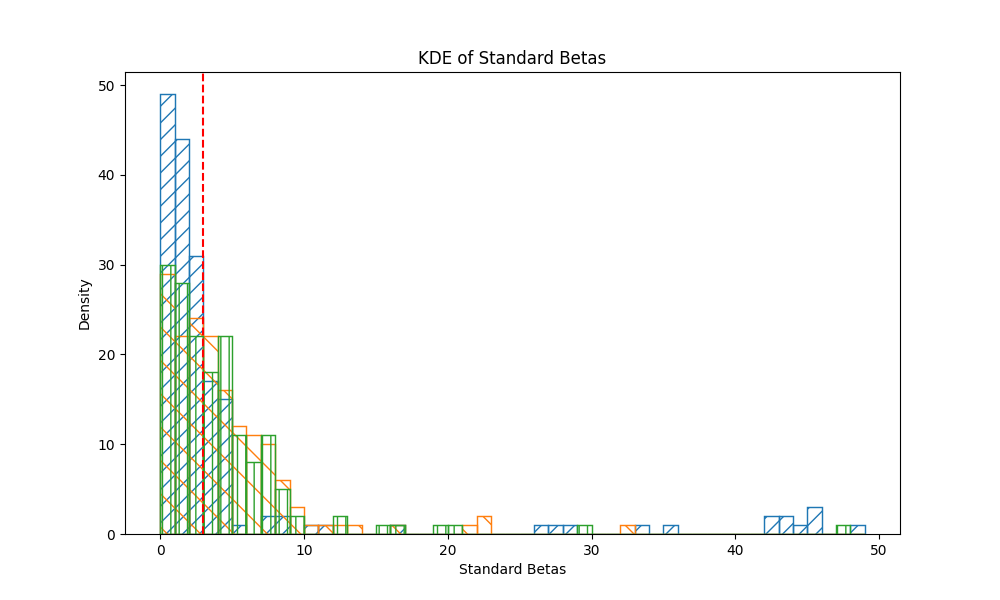

In [14]:
import seaborn as sns

mcs_standard_betas = abs(mcs['coefs_mean'][1:]) / np.sqrt(mcs['coefs_var'][1:])
gjk_standard_betas = abs(gjk['coefs_mean'][1:]) / np.sqrt(gjk['coefs_var'][1:])
ddjk_standard_betas = abs(ddjk['coefs_mean'][1:]) / np.sqrt(ddjk['coefs_var'][1:])

plt.figure(figsize=(10, 6))
sns.histplot(mcs_standard_betas, bins=range(0,50), fill=False, hatch='//', kde=False)
sns.histplot(gjk_standard_betas, bins=range(0,50), fill=False, hatch='\\', kde=False)
sns.histplot(ddjk_standard_betas, bins=range(0,50), fill=False, hatch='||', kde=False)

plt.axvline(3, color='red', linestyle='--')
plt.title('KDE of Standard Betas')
plt.xlabel('Standard Betas')
plt.ylabel('Density')
plt.show()

Finally, here we see that __most__ of the regression coefficients are insignificant at the $3-\sigma$ level no matter how you calculate your $\mathrm{Var}\left(\beta\right)$'s. We could use this information to remove the "insignificant" coefficients, or we can leave them in knowing that the feature weighting is going to make these coefficients not have a significant contribution to the model anyways. 

One of the major benefits of doing an analysis of this is that we can propagate the uncertainties to our predictions, which we'll do below.

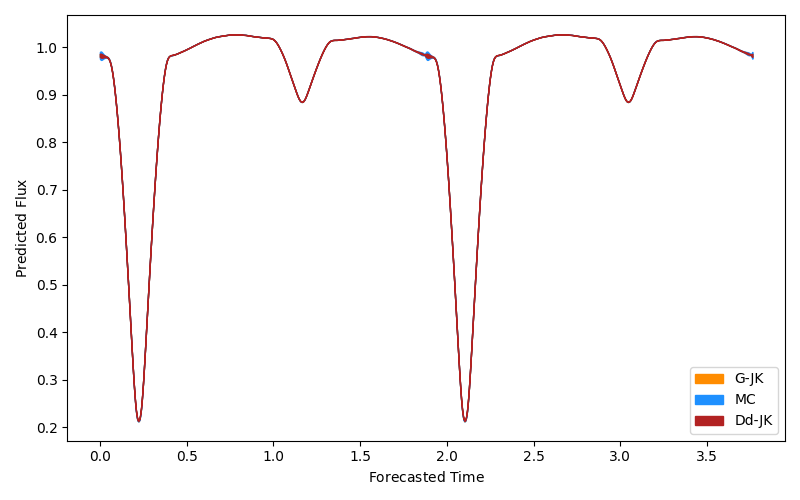

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

t_pred = np.linspace(0, 2*period, 1000)

gjk_p1 = fwls.predict(t_pred, coefficients=gjk['coefs_mean'] + 3 * np.sqrt(gjk['coefs_var']))
gjk_m1 = fwls.predict(t_pred, coefficients=gjk['coefs_mean'] - 3 * np.sqrt(gjk['coefs_var']))

mcs_p1 = fwls.predict(t_pred, coefficients=mcs['coefs_mean'] + 3 * np.sqrt(mcs['coefs_var']))
mcs_m1 = fwls.predict(t_pred, coefficients=mcs['coefs_mean'] - 3 * np.sqrt(mcs['coefs_var']))

ddjk_p1 = fwls.predict(t_pred, coefficients=ddjk['coefs_mean'] + 3 * np.sqrt(ddjk['coefs_var']))
ddjk_m1 = fwls.predict(t_pred, coefficients=ddjk['coefs_mean'] - 3 * np.sqrt(ddjk['coefs_var']))


ax.fill_between(t_pred, y1=gjk_m1[1], y2=gjk_p1[1], color='darkorange', label='G-JK')
ax.fill_between(t_pred, y1=mcs_m1[1], y2=mcs_p1[1], color='dodgerblue', label='MC')
ax.fill_between(t_pred, y1=ddjk_m1[1], y2=ddjk_p1[1], color='firebrick', label='Dd-JK')

ax.set_xlabel(r'${\rm Forecasted~Time}$')
ax.set_ylabel(r'${\rm Predicted~Flux}$')
ax.legend()

fig.tight_layout()
